# IPP with Non-Point FoV

In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np

from sgptools.utils.metrics import *
from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.models.core.osgpr import *
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params
from sgptools.models.continuous_sgp import *
from sgptools.models.core.transformations import *
from gpflow.utilities.traversal import print_summary

from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

from time import time
from copy import deepcopy

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
'''
Utility to map the inducing points to FoV vertices
'''
def get_vertices(Xu, X_fov):
    X_fov = X_fov.reshape(len(Xu), -1, 2)
    vertices = np.zeros((len(Xu), 5, 2))
    vertices[:, 0] = X_fov.min(axis=1)
    vertices[:, 1] = np.array([X_fov[:, :, 0].min(axis=1), 
                              X_fov[:, :, 1].max(axis=1)]).T
    vertices[:, 2] = X_fov.max(axis=1)
    vertices[:, 3] = np.array([X_fov[:, :, 0].max(axis=1), 
                              X_fov[:, :, 1].min(axis=1)]).T
    vertices[:, 4] = X_fov.mean(axis=1)

    dists = pairwise_distances(vertices[:, 4], Y=Xu[:, :2], 
                               metric='euclidean')
    _, idx = linear_sum_assignment(dists)

    vertices[:, 4] = Xu[idx][:, :2]
    return vertices

'''
Method to plot the solution with FoVs and environment reconstruction
'''
def plot_results(X_inducing, X_fov, fname=None):
    # Setup 3D plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

    # Plot the reconstructed environment state
    sensor_data = cont2disc(X_fov, X, y)
    y_pred, _ = get_reconstruction(sensor_data, X_test, 
                                   noise_variance_opt, kernel_opt)
    norm = colors.Normalize(y_train.min(), y_train.max())
    _ = ax.plot_surface(X_test[:, 0].reshape(test_dim),
                        X_test[:, 1].reshape(test_dim),
                        np.atleast_2d(-0.1),
                        facecolors=plt.cm.jet(norm(y_pred.reshape(test_dim))),
                        shade=False,
                        alpha=0.8,
                        zorder=0)

    # Plot the solution path
    ax.scatter(X_inducing[:, 0], 
               X_inducing[:, 1], 
               X_inducing[:, 2], c='C3')
    ax.plot(X_inducing[:, 0], X_inducing[:, 1], X_inducing[:, 2], 'k-')

    # Plot the FoV vertices
    vertices = get_vertices(X_inducing, X_fov)
    for i in range(vertices.shape[0]):
        color = 'C3'
        verts = []
        verts.append([vertices[i, 0], vertices[i, 1], 
                      vertices[i, 2], vertices[i, 3]])
        fov = Polygon(np.array(verts)[0, :, :2],
                      linewidth=1.5, 
                      edgecolor=color,
                      facecolor=color,
                      fill=False,
                      zorder=15)
        ax.add_patch(fov)
        art3d.pathpatch_2d_to_3d(fov)

    # Configure other plot settings
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5)
    ax.set_ylim(np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5)
    ax.set_zlim(0, 14)

    ax.view_init(elev=30, azim=45+180)
    ax.set_title(f'Num Waypoints: {num_placements}, RMSE: {get_rmse(y_pred, y_test):.2f}\nData Field Reconstruction', y=0.99)

    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    plt.show()

## Generate synthetic data and initial SGP hyperparameters

Optimized Hyperparameters
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.8371517535182331  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [2.45802 2.50701]   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float6

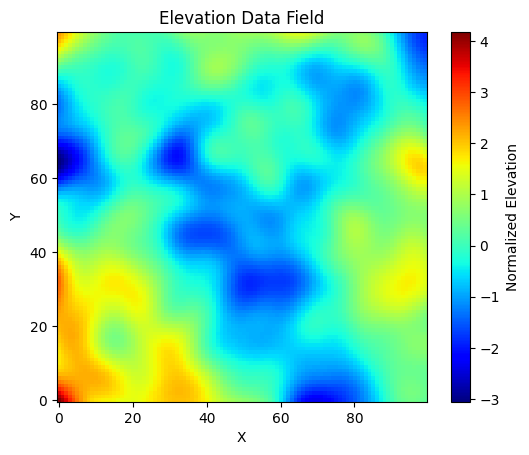

In [3]:
# Get the synthetic elevation data
X_train, y_train, X_test, y_test, candidates, X, y = get_dataset(random_seed=0)
train_dim = np.sqrt(X_train.shape[0]).astype(int)

# Train a GP and get the model parameters
print('Optimized Hyperparameters')
_, noise_variance_opt, kernel_opt = get_model_params(X_train, y_train, 
                                                     lengthscales=[1.0, 1.0], 
                                                     optimizer='scipy')

# Build a new test set on a grid for easy plotting in a 3D plot
gpr = gpflow.models.GPR((X_test, y_test),
                        noise_variance=noise_variance_opt,
                        kernel=kernel_opt)
test_dim = (100, 100)
X_test1 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), test_dim[0])
X_test2 = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), test_dim[1])
X_test1, X_test2 = np.meshgrid(X_test1, X_test2)
X_test = np.stack([X_test1.ravel(), X_test2.ravel()], axis=1)
y_test, y_var = gpr.predict_f(X_test)
y_test = y_test.numpy()

# Plot the data field
plt.imshow(y_test.reshape(test_dim), cmap="jet", origin='lower')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Elevation Data Field')
plt.colorbar(label='Normalized Elevation')
plt.show()

## Generate the IPP solution

In [4]:
num_robots = 1
num_placements = 9
num_side = 5  # Use a 5x5 point FoV approximation

# Setup the hyperparameters
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[3.0, 3.0], 
                                             optimizer='scipy',
                                             max_steps=0,
                                             print_params=False)

# Get initial inducing points
Xu_init = get_inducing_pts(X_train, num_placements)
# Initalize the height dimension at 2.0 for all points
Xu_init = np.concatenate((Xu_init, np.ones((Xu_init.shape[0], 1))*2.0), axis=1)
Xu_init[:, :2] = run_tsp(Xu_init[:, :2])[0][0]

# Initialize the non-point FoV IPP model and optimize it
transform = SquareHeightTransform(num_side=num_side)
sgpr, _ = continuous_sgp(num_placements,
                         X_train, 
                         noise_variance,
                         kernel,
                         transform=transform,
                         Xu_init=Xu_init.copy())
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()

## Initial Solution

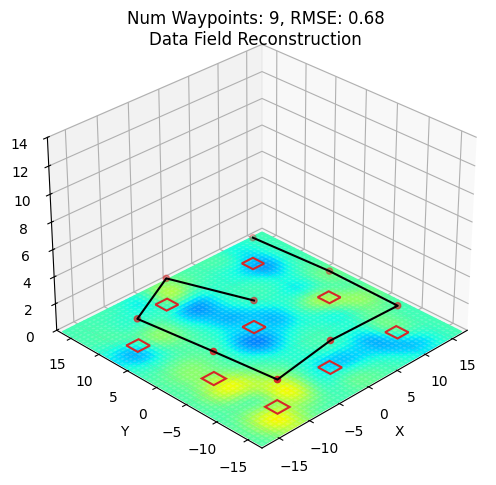

In [5]:
plot_results(Xu_init.reshape(-1, 3), 
             sgpr.transform.expand(Xu_init.reshape(-1, 3)).numpy())

## Optimized Solution

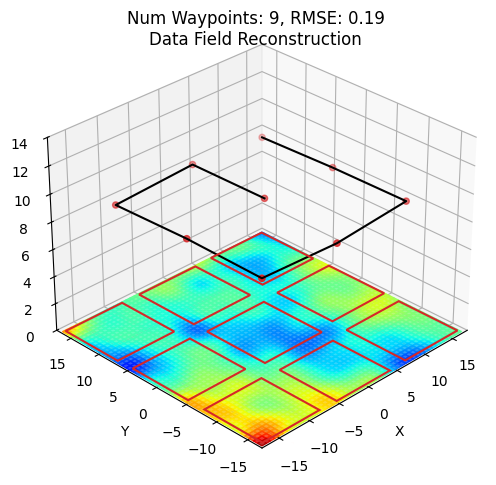

In [6]:
plot_results(sgp_sol_sp.reshape(-1, 3), 
             sgpr.transform.expand(sgp_sol_sp.reshape(-1, 3)).numpy())